In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nbformat.sign import algorithms
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
df = pd.read_csv("Bengaluru_House_Data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [3]:
df.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [5]:
df.shape

(13320, 9)

In [6]:
df.groupby("area_type")["area_type"].agg("count")

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

***We will assume that availability isnt important for price , to make our model more-manageable***

In [7]:
df.drop(["availability","area_type","balcony","society"], axis=1, inplace=True)

In [8]:
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


***Data cleaning***

In [9]:
df.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [10]:
df.dropna(inplace=True)
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [11]:
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [12]:
df.shape

(13246, 5)

In [13]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
13315    False
13316    False
13317    False
13318    False
13319     True
Length: 13246, dtype: bool

***Converting size to more meaningfully form***

In [14]:
df["size"].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [15]:
df["bhk"] = df["size"].apply(lambda x: int(x.split()[0]))

In [16]:
df.head()

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00,4
2,Uttarahalli,3 BHK,1440,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00,3
4,Kothanur,2 BHK,1200,2.0,51.00,2


In [17]:
df["bhk"].unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [18]:
df[df["bhk"]>20]

,location,size,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,27 BHK,8000,27.0,230.0,27
4684,Munnekollal,43 Bedroom,2400,40.0,660.0,43


In [19]:
df["total_sqft"].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      shape=(2067,), dtype=object)

In [20]:
def is_float(sqft):
    try:
        float(sqft)
    except ValueError:
        return False
    return True


In [21]:
df[~df["total_sqft"].apply(is_float)].head(20)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


In [22]:
def get_valid_sqft(x):
    try:
        tokens = x.split('-')
        if len(tokens) == 2:
            float(tokens[0])
            float(tokens[1])
            return True
        else:
            float(x)
            return True
    except ValueError:
        return False


In [23]:
df[~df["total_sqft"].apply(get_valid_sqft)].head(10)

,location,size,total_sqft,bath,price,bhk
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.5,1
648,Arekere,9 Bedroom,4125Perch,9.0,265.0,9
775,Basavanagara,1 BHK,1000Sq. Meter,2.0,93.0,1
872,Singapura Village,2 BHK,1100Sq. Yards,2.0,45.0,2
1019,Marathi Layout,1 Bedroom,5.31Acres,1.0,110.0,1
1086,Narasapura,2 Bedroom,30Acres,2.0,29.5,2
1400,Chamrajpet,9 BHK,716Sq. Meter,9.0,296.0,9
1712,Singena Agrahara,3 Bedroom,1500Sq. Meter,3.0,95.0,3
1743,Hosa Road,3 BHK,142.61Sq. Meter,3.0,115.0,3
1821,Sarjapur,3 Bedroom,1574Sq. Yards,3.0,76.0,3


In [24]:
df = df[df["total_sqft"].apply(get_valid_sqft)]

In [25]:
def convert_sqft_to_num(x):
    try:
        tokens = x.split('-')
        if len(tokens) == 2:
            sum = float(tokens[0])+float(tokens[1])
            avg_of_sqft = float(sum)/len(tokens)
            return avg_of_sqft
        else:
            return float(x)
    except ValueError:
        return False


In [26]:
convert_sqft_to_num("2160")

2160.0

In [27]:
convert_sqft_to_num("2400- 2850")

2625.0

In [28]:
df2 = df.copy()
df2["total_sqft"] = df["total_sqft"].apply(convert_sqft_to_num)
df2.head(5)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3
4,Kothanur,2 BHK,1200.0,2.0,51.00,2


***Feature Engineering***

In [29]:
df3 = df2.copy()

In [30]:
df3["price_per_sqft"] = (df3["price"]*100000)/df3["total_sqft"]
df3.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [31]:
df["location"].unique()

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       '12th cross srinivas nagar banshankari 3rd stage',
       'Havanur extension', 'Abshot Layout'], shape=(1298,), dtype=object)

In [32]:
df3["location"] = df3["location"].apply(lambda x: x.strip())
location_status = df3.groupby("location")["location"].agg("count").sort_values(ascending=True)

In [33]:
location_status

location
1 Annasandrapalya         1
Kodanda Reddy Layout      1
Konappana Agrahara        1
Kudlu Village,            1
Kumbhena Agrahara         1
                       ... 
Thanisandra             235
Kanakpura Road          264
Electronic City         304
Sarjapur  Road          392
Whitefield              533
Name: location, Length: 1287, dtype: int64

In [34]:
len(location_status[location_status<=10])

1047

In [35]:
location_stats_less_10 = location_status[location_status<=10]

In [36]:
location_stats_less_10

location
1 Annasandrapalya        1
Kodanda Reddy Layout     1
Konappana Agrahara       1
Kudlu Village,           1
Kumbhena Agrahara        1
                        ..
Kalkere                 10
Thyagaraja Nagar        10
Sadashiva Nagar         10
BTM 1st Stage           10
Dodsworth Layout        10
Name: location, Length: 1047, dtype: int64

In [37]:
print(df3.location.nunique())

1287


In [38]:
df3.location = df3.location.apply(lambda x : "other" if x in location_stats_less_10 else x)

In [39]:
df3[df3.location == "other"]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804
18,other,3 BHK,2770.0,4.0,290.00,3,10469.314079
19,other,2 BHK,1100.0,2.0,48.00,2,4363.636364
25,other,3 BHK,1250.0,3.0,56.00,3,4480.000000
42,other,1 BHK,600.0,1.0,38.00,1,6333.333333
...,...,...,...,...,...,...,...
13291,other,1 Bedroom,812.0,1.0,26.00,1,3201.970443
13292,other,3 BHK,1440.0,2.0,63.93,3,4439.583333
13302,other,2 BHK,1075.0,2.0,48.00,2,4465.116279
13306,other,4 Bedroom,1200.0,5.0,325.00,4,27083.333333


In [40]:
df3.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


***Removing Outliers***

In [41]:
df3[df3.total_sqft/df3.bhk < 300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


In [42]:
df3.shape

(13200, 7)

In [43]:
df4 = df3[df3.total_sqft/df3.bhk >= 300]
df4.shape

(12456, 7)

In [44]:
print(f"max : {df4.price_per_sqft.max()}")
print(f"min : {df4.price_per_sqft.min()}")


max : 176470.58823529413
min : 267.82981328435875


In [45]:
df4.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [46]:
def remove_pps_outliers(dataf):
    df_out = pd.DataFrame()
    for key, subdf in dataf.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df5 = remove_pps_outliers(df4)
df5.shape
#location based removing outliers

(10242, 7)

In [47]:
df5.price_per_sqft.describe()

count    10242.000000
mean      5657.735993
std       2266.368844
min       1250.000000
25%       4244.796706
50%       5172.846776
75%       6426.000592
max      24509.803922
Name: price_per_sqft, dtype: float64

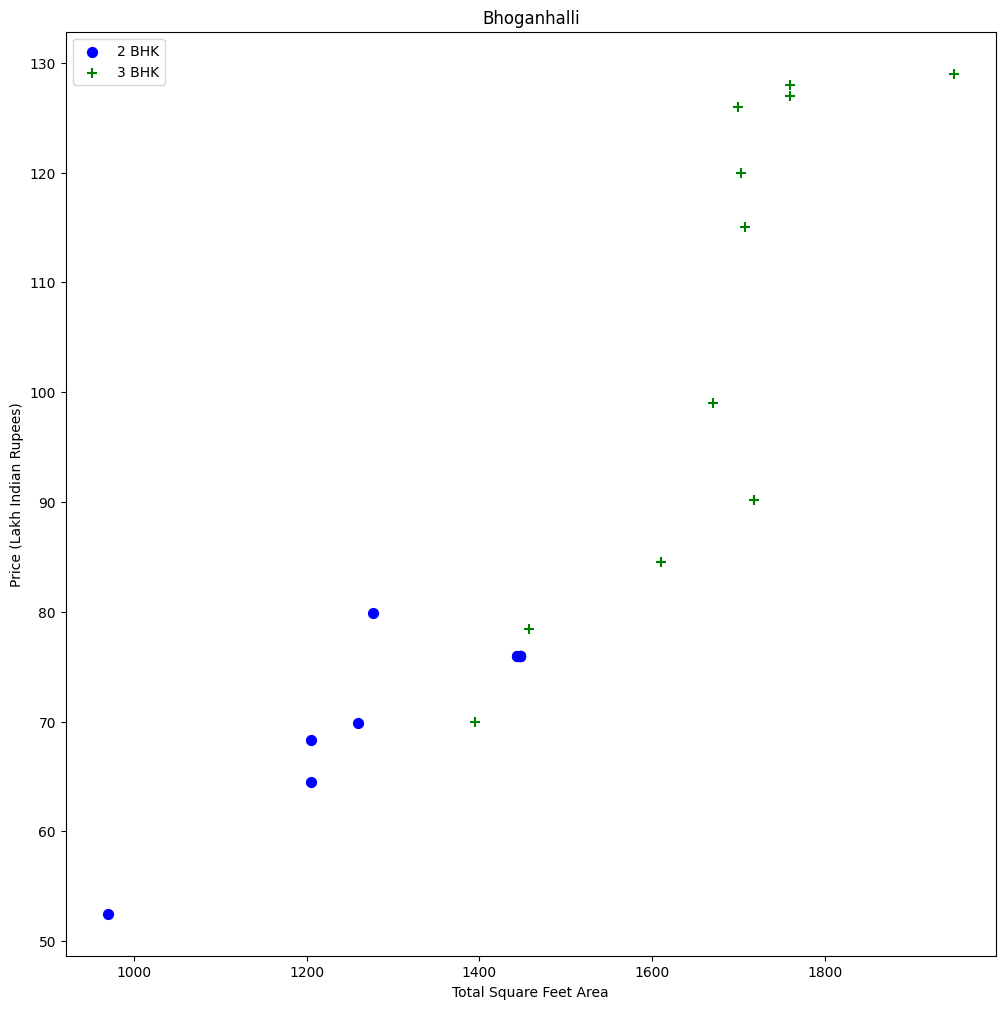

In [48]:
import matplotlib

def price_plot_scatter_basedloc(dataf,location):
    bhk2 = dataf[(dataf.location==location) & (dataf.bhk==2)]
    bhk3 = dataf[(dataf.location==location) & (dataf.bhk==3)]
    plt.figure(figsize = (12,12))
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()

price_plot_scatter_basedloc(df5,"Bhoganhalli")


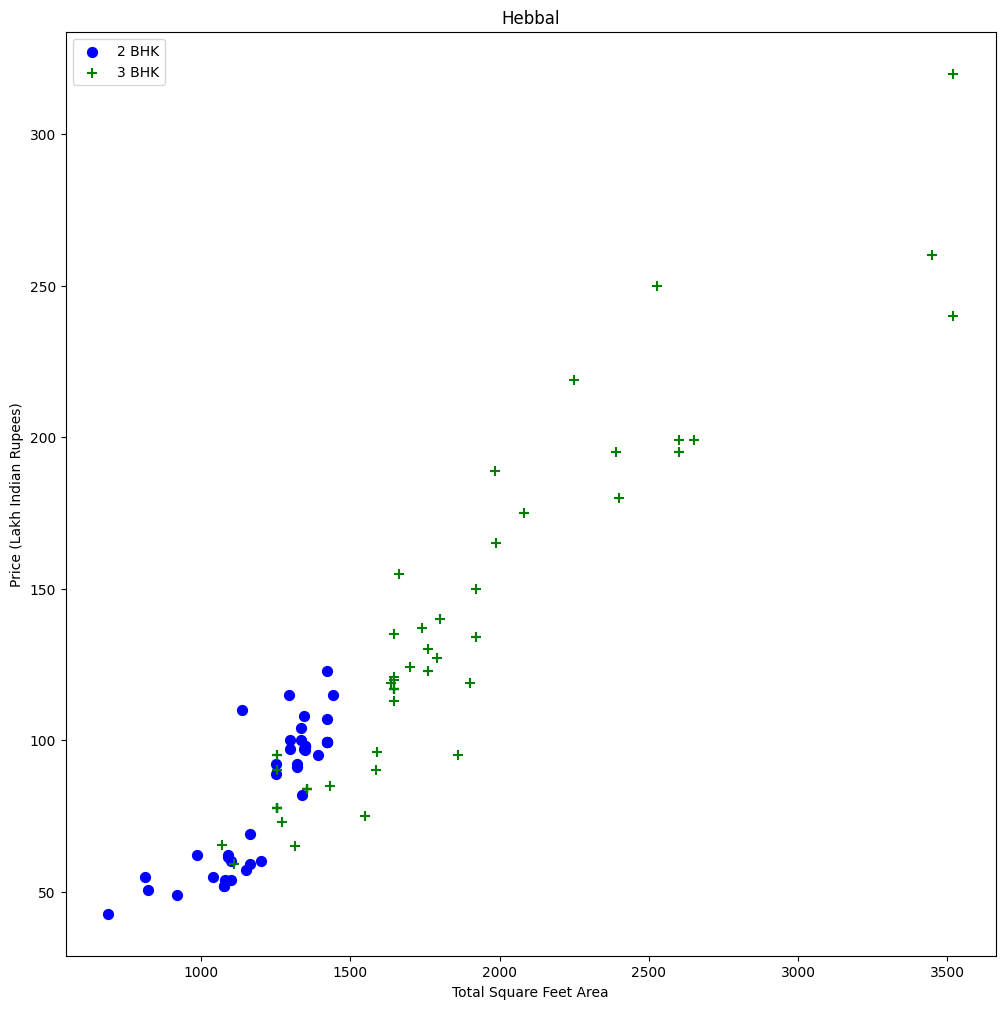

In [49]:
price_plot_scatter_basedloc(df5,"Hebbal")

**We are now calculating mean,std and count for every each location.In addition to this grouping locations based on their bhk's to detect if value of n bhk place is less than (n-1) bhk's mean , because it means a discrepancy on records.If it less , we are dropping this values from data frame**

For example, we should also remove properties where for the same location,
the price of (for example) a **3 bedroom apartment** is **less than** a **2 bedroom apartment**
(with the same square ft area).

What we will do is: for a given location, we will build a dictionary of stats per **BHK**, i.e.


***Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment (below)***
```python
{
    '1': {
        'mean': 4000,
        'std': 2000,
        'count': 34
    },
    '2': {
        'mean': 4300,
        'std': 2300,
        'count': 22
    },
}


In [50]:
def remove_bhk_outliers(dataf):
    exclude_indices = np.array([])
    for location, location_df in dataf.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return dataf.drop(exclude_indices,axis='index')

df6 = remove_bhk_outliers(df5)
df6.shape

(7317, 7)

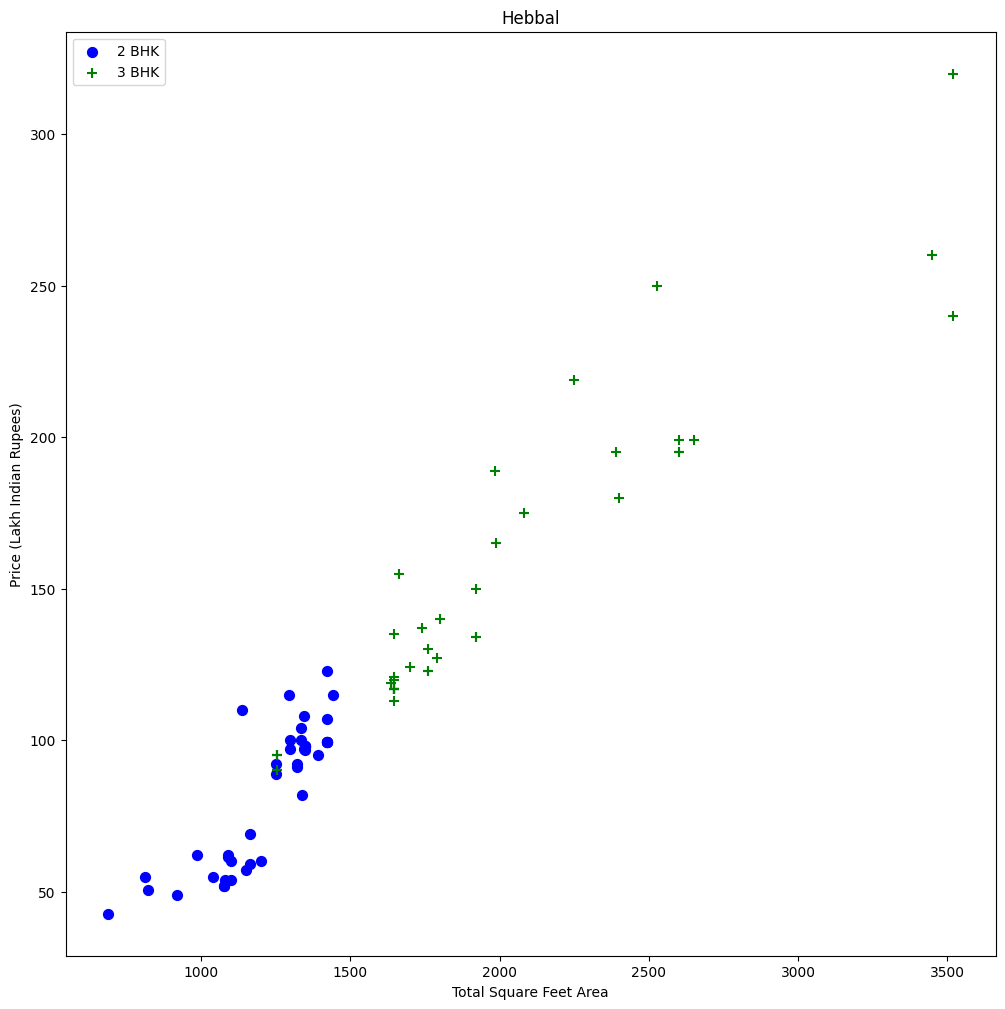

In [51]:
price_plot_scatter_basedloc(df6,"Hebbal")

In [52]:
df6.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

In [53]:
df6[df6["bath"] > 10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


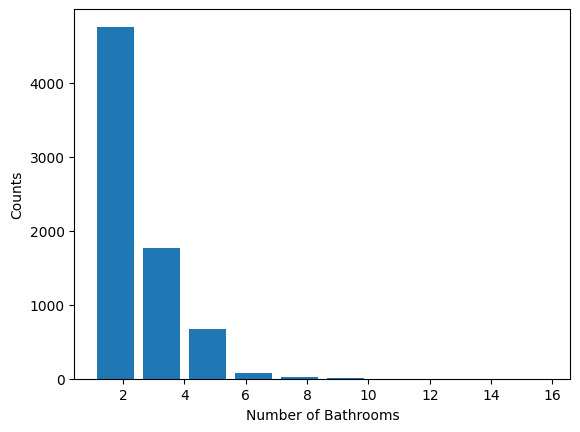

In [54]:
plt.hist(df6.bath,rwidth=0.8)
plt.xlabel("Number of Bathrooms")
plt.ylabel("Counts")
plt.show()

**Removing values that its bathroom is higher than bhk+2**

In [55]:
df6[df6["bath"] > (df6["bhk"]+2)]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


In [56]:
df7 = df6[df6["bath"] < (df6["bhk"]+2)]
df7.shape

(7239, 7)

In [57]:
df7.head(5)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491
2,1st Block Jayanagar,3 BHK,1875.0,2.0,235.0,3,12533.333333
3,1st Block Jayanagar,3 BHK,1200.0,2.0,130.0,3,10833.333333
4,1st Block Jayanagar,2 BHK,1235.0,2.0,148.0,2,11983.805668


**Model building**

In [164]:
df8 = df7.drop(["price_per_sqft","size"],axis=1)
df8.head(10)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2
5,1st Block Jayanagar,2750.0,4.0,413.0,4
6,1st Block Jayanagar,2450.0,4.0,368.0,4
8,1st Phase JP Nagar,1875.0,3.0,167.0,3
9,1st Phase JP Nagar,1500.0,5.0,85.0,5
10,1st Phase JP Nagar,2065.0,4.0,210.0,3


In [165]:
df_dummies = pd.get_dummies(df8["location"],dtype=int)
df_dummies.head(10)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [166]:
df9 = pd.concat([df8,df_dummies],axis=1)
df9.head(10)

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,1200.0,2.0,130.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1235.0,2.0,148.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1st Block Jayanagar,2750.0,4.0,413.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1st Block Jayanagar,2450.0,4.0,368.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1st Phase JP Nagar,1875.0,3.0,167.0,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1st Phase JP Nagar,1500.0,5.0,85.0,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,1st Phase JP Nagar,2065.0,4.0,210.0,3,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [181]:
df9.shape

(7239, 246)

In [182]:
df9.isnull().sum()

location              0
total_sqft            0
bath                  0
price                 0
bhk                   0
                     ..
Yelahanka             0
Yelahanka New Town    0
Yelenahalli           0
Yeshwanthpur          0
other                 0
Length: 246, dtype: int64

In [183]:
df10 = df9.drop(["location"],axis=1)
df10.isnull().sum()

total_sqft             0
bath                   0
price                  0
bhk                    0
1st Block Jayanagar    0
                      ..
Yelahanka              0
Yelahanka New Town     0
Yelenahalli            0
Yeshwanthpur           0
other                  0
Length: 245, dtype: int64

In [184]:
df11 = df10.drop(["other"],axis=1)
df11.isnull().sum()

total_sqft             0
bath                   0
price                  0
bhk                    0
1st Block Jayanagar    0
                      ..
Yelachenahalli         0
Yelahanka              0
Yelahanka New Town     0
Yelenahalli            0
Yeshwanthpur           0
Length: 244, dtype: int64

In [185]:
X = df11.drop(["price"],axis = 1)
X.head(2)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [186]:
y = df11.price
y.head(2)

0    428.0
1    194.0
Name: price, dtype: float64

In [187]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [188]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.score(X_test, y_test)

0.8087560153181974

**Measuring accuracy of our Linear regression by using K fold cross validaion**

In [189]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv )

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

**Find best model using GridSearchCV**

In [190]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import GridSearchCV, ShuffleSplit
import pandas as pd

def find_best_model_using_gridsearchcv(X, y):
    ml_algorithms = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False],
                'copy_X': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error','friedman_mse'],  # 'mse' deprecated
                'splitter': ['best', 'random']
            }
        },
        "Gradient boosting regressor": {
            'model': GradientBoostingRegressor(),
            "params":{
                'learning_rate': [0.01, 0.1],
                'n_estimators': [100, 200],
                'max_depth': [3, 5]
            }
        }
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    for algo_name, config in ml_algorithms.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores, columns=['model','best_score','best_params'])
find_best_model_using_gridsearchcv(X, y)

,model,best_score,best_params
0,linear_regression,0.847951,"{'copy_X': True, 'fit_intercept': False}"
1,lasso,0.726774,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.736286,"{'criterion': 'friedman_mse', 'splitter': 'ran..."
3,Gradient boosting regressor,0.783893,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


In [191]:
X.columns

Index(['total_sqft', 'bath', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       '6th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=243)

In [192]:
def predict_price(location,sqft,bath,bhk):
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return regressor.predict([x])[0]

In [193]:
predict_price('1st Phase JP Nagar',1000,2,2)

/Users/anil/Desktop/Real Estate Price Prediction/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(98.96338026083713)

In [195]:
predict_price('1st Phase JP Nagar',1000,2,3)

/Users/anil/Desktop/Real Estate Price Prediction/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(96.97000506939757)

In [196]:
predict_price('1st Phase JP Nagar',1000,2,3)

/Users/anil/Desktop/Real Estate Price Prediction/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(96.97000506939757)

In [197]:
predict_price('Hebbal',1000,2,2)

/Users/anil/Desktop/Real Estate Price Prediction/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(73.71630491162463)

In [198]:
import pickle
with open("h ouse_price.pkl", "wb") as f:
    pickle.dump(regressor, f)

In [199]:
import json
columns = {
    "data_columns" :[col.lower() for col in X.columns]

}
with open("backend/model/columns_json.json", "w") as f:
    f.write(json.dumps(columns))